In [1]:
import pandas as pd
import pymorphy2
import re
import transliterate as tr
import seaborn as sns
import numpy as np
import spacy
from sklearn.cluster import KMeans
import helpers

Using Russia server backend.


In [2]:
profiles_cols = ['id', 'firstname', 'lastname', 'sex', 'birthday']
profiles = pd.read_csv('data/db/users.csv', usecols=profiles_cols)
print(len(profiles))

13941


not set:  8286
f    4001
m    1654
Name: sex, dtype: int64


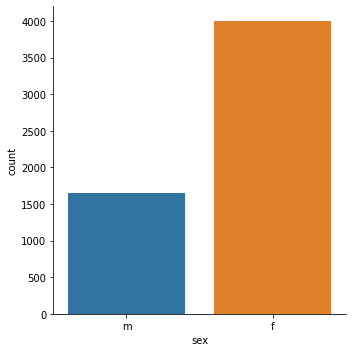

In [3]:
without_sex = profiles[profiles['sex'].isnull()]
print('not set: ', without_sex['id'].count())
print(profiles['sex'].value_counts())

sns.catplot(x="sex", kind="count", data=profiles)

In [4]:
ru_names = pd.read_json('data/names_table.jsonl', lines=True)
ru_names = ru_names[ru_names['gender'] != 'u']
print('ru names:', len(ru_names))

ru_surnames = pd.read_json('data/surnames_table.jsonl', lines=True)
ru_surnames = ru_surnames[ru_surnames['gender'] != 'u']
print('ru surnames:', len(ru_surnames))

names = ru_names.set_index('text')['gender'].to_dict()
surnames = ru_surnames.set_index('text')['gender'].to_dict()

us_names = pd.read_csv('data/fake_us_names.csv')
us_name_gender = us_names.set_index('GivenName')['Gender'].to_dict()
for name in us_name_gender.keys():
    us_name_gender[name] = us_name_gender[name][0]
    
print('us names:', len(us_name_gender.keys()))
names.update(us_name_gender)

us_surname_gender = us_names.set_index('Surname')['Gender'].to_dict()
for name in us_surname_gender.keys():
    us_surname_gender[name] = us_surname_gender[name][0]
print('us surnames:', len(us_surname_gender.keys()))
surnames.update(us_surname_gender)

print('total names:', len(names))
print('total surnames:', len(surnames))

ru names: 4791
ru surnames: 37708
us names: 4043
us surnames: 15347
total names: 8834
total surnames: 53055


In [5]:
df = profiles[['firstname', 'lastname', 'sex']]
df = df.to_dict("records")

ru_morph = pymorphy2.MorphAnalyzer(lang='ru')
gender_list = []
gender_count = 0

for row in df:
    if pd.isna(row['sex']):
        name = str(row['firstname'])
        name = name[0].upper() + name[1:].lower()
        gender = names.get(name)
        
        if not gender:
            surname = str(row['lastname'])
            surname = surname[0].upper() + surname[1:].lower()
            gender = surnames.get(surname)
            
        if not gender and not bool(re.search('[а-яА-Я]', name)):
            name = tr.translit(name, 'ru')
            gender = names.get(name)
        
        
        if not gender:
            parsed_word = ru_morph.parse(name)[0]
            parsed_gender = parsed_word.tag.gender
            if parsed_gender and parsed_gender[0] != 'n':
                gender = parsed_gender[0]
                   
        if gender:
            gender_count += 1   
    else:
        gender = row['sex']
            
    gender_list.append(gender)

profiles['sex'] = gender_list
print(gender_count, 'gender is set')

7998 gender is set


not set:  288
f    9724
m    3929
Name: sex, dtype: int64


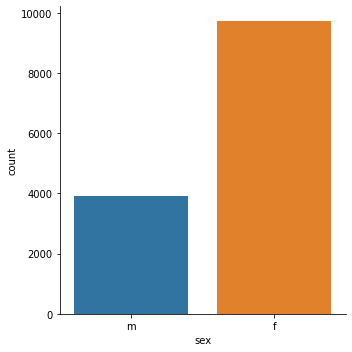

In [6]:
without_sex = profiles[profiles['sex'].isnull()]

print('not set: ', without_sex['id'].count())
print(profiles['sex'].value_counts())

sns.catplot(x="sex", kind="count", data=profiles)

In [7]:
wishes = pd.read_csv('data/db/wishes.csv')
wishes.head()

,id,ctime,mtime,creator_id,title,description,price,color,link,is_private,is_fulfilled,currency,assignee_id,is_idea,parent_wish_id,is_from_idea,is_deleted,photo_id
0,591cb63b314b62000f186f41,2017-05-17 20:44:43.000000,2017-05-31 09:20:21.000000,59161d458ef861000f59f975,No Pic,NaN,1000.0,#02b7b3,NaN,False,False,RUB,591774818ef861000f59f97f,False,NaN,False,False,NaN
1,5929c6a11bfc73000f07774d,2017-05-27 18:34:09.000000,2017-05-27 18:34:09.000000,59161d458ef861000f59f975,Private!!,my very private wish,10000.0,#4a4a4a,NaN,True,False,RUB,NaN,False,NaN,False,False,NaN
2,592e6636424d49000ffc4a93,2017-05-31 06:44:06.000000,2017-05-31 07:22:01.000000,591831f18ef861000f59f981,xx,NaN,NaN,#782d92,NaN,False,True,RUB,NaN,False,NaN,False,False,NaN
3,592fe527424d49000ffc4aaf,2017-06-01 09:57:59.000000,2017-06-21 09:09:31.000000,59161d458ef861000f59f975,https://www.amazon.com/dp/B015TJD0Y4/ref=ods_g...,NaN,NaN,#B24D00,NaN,False,False,RUB,NaN,False,NaN,False,False,NaN
4,59536890c5fcf0000f7b71ec,2017-06-28 08:28:00.000000,2017-06-28 08:28:00.000000,59161d458ef861000f59f975,Apple HomePod,NaN,NaN,#008c79,NaN,False,False,RUB,NaN,False,NaN,False,False,NaN


In [8]:
print('all wishes:', wishes['id'].count())
print('no assignee:', wishes[wishes['assignee_id'].isnull()]['id'].count())

print('\nFulfilled wishes')
print(wishes['is_fulfilled'].value_counts())

all wishes: 87845
no assignee: 79938

Fulfilled wishes
False    76438
True     11407
Name: is_fulfilled, dtype: int64


In [9]:
print('All wishes')
wishes['title'].value_counts()[:20]

All wishes


Книга                                                     346
Сумка                                                     338
Серьги                                                    270
Стайлер Dyson Airwrap Complete с сумкой и чехлом          239
Кольцо                                                    229
Apple Apple AirPods                                       227
Духи                                                      184
Портативный ультразвуковой увлажнитель воздуха, 300 мл    139
Apple AirPods Pro                                         138
Apple Watch 4                                             132
Пижама                                                    131
Постельное белье                                          121
Футболка                                                  121
Браслет                                                   119
Платье                                                    115
Часы                                                      115
Классный

In [10]:
print('Fulfilled wishes')
wishes[wishes['is_fulfilled'] == True]['title'].value_counts()[:20]

Fulfilled wishes


Книга                  51
Серьги                 36
Сумка                  30
Apple Apple AirPods    30
Рюкзак                 28
Духи                   28
Увлажнитель воздуха    18
Наушники               17
Пижама                 17
Коврик для йоги        16
Кольцо                 15
AirPods Pro            15
Футболка               14
Парфюм                 14
Постельное белье       12
Свеча                  12
Браслет                12
Apple Watch            12
Маска для сна          11
Часы                   11
Name: title, dtype: int64

not set:  9310


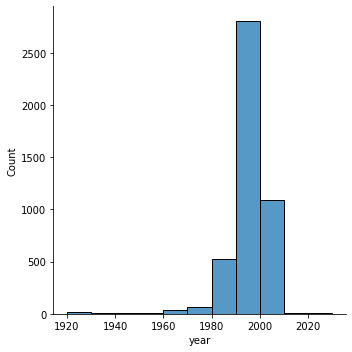

In [11]:
def get_year(value):
    if pd.isna(value):
        return value
    return int(str(value).split('-')[0])

profiles['year'] = profiles.apply(lambda row: get_year(row['birthday']), axis=1)

without_birthday = profiles[profiles['birthday'].isnull()]
print('not set: ', without_birthday['id'].count())

sns.displot(profiles["year"], binwidth=10, binrange=[1920,2021])

In [12]:
wishes = helpers.filter_wishes(wishes)
df = pd.merge(wishes, profiles, left_on='creator_id', right_on='id')
df.head()

,id_x,ctime,mtime,creator_id,title,description,price,color,link,is_private,...,parent_wish_id,is_from_idea,is_deleted,photo_id,id_y,birthday,sex,lastname,firstname,year
0,591cb63b314b62000f186f41,2017-05-17 20:44:43.000000,2017-05-31 09:20:21.000000,59161d458ef861000f59f975,No Pic,NaN,1000.0,#02b7b3,NaN,False,...,NaN,False,False,NaN,59161d458ef861000f59f975,1989-11-07,m,Vassilyev,Sergey,1989.0
1,5929c6a11bfc73000f07774d,2017-05-27 18:34:09.000000,2017-05-27 18:34:09.000000,59161d458ef861000f59f975,Private!!,my very private wish,10000.0,#4a4a4a,NaN,True,...,NaN,False,False,NaN,59161d458ef861000f59f975,1989-11-07,m,Vassilyev,Sergey,1989.0
2,592fe527424d49000ffc4aaf,2017-06-01 09:57:59.000000,2017-06-21 09:09:31.000000,59161d458ef861000f59f975,https://www.amazon.com/dp/B015TJD0Y4/ref=ods_g...,NaN,NaN,#B24D00,NaN,False,...,NaN,False,False,NaN,59161d458ef861000f59f975,1989-11-07,m,Vassilyev,Sergey,1989.0
3,59536890c5fcf0000f7b71ec,2017-06-28 08:28:00.000000,2017-06-28 08:28:00.000000,59161d458ef861000f59f975,Apple HomePod,NaN,NaN,#008c79,NaN,False,...,NaN,False,False,NaN,59161d458ef861000f59f975,1989-11-07,m,Vassilyev,Sergey,1989.0
4,5981df67f03a9e000ff0dde9,2017-08-02 14:19:19.000000,2017-08-02 14:19:24.000000,59161d458ef861000f59f975,ttt,123,123.0,#008c79,NaN,True,...,NaN,False,False,NaN,59161d458ef861000f59f975,1989-11-07,m,Vassilyev,Sergey,1989.0


In [13]:
print('Male wishes: \n')
print(df[df['sex']=='m']['title'].value_counts()[:10])

print('\n\nFemale wishes: \n')
print(df[df['sex']=='f']['title'].value_counts()[:10])

Male wishes: 

Apple Apple AirPods                                  61
Увлажнитель воздуха Xaiomi                           56
Ноутбук Apple MacBook Pro 16 TB i7 2.6/16/512 SSD    42
Bose SoundLink Revolve Tripple Black                 40
Apple AirPods Pro                                    36
Подушка Casper                                       34
Apple Watch 4                                        30
Стайлер Dyson Airwrap Complete с сумкой и чехлом     27
Бутылка для изготовления льда Kumma                  26
Лампа Casper                                         26
Name: title, dtype: int64


Female wishes: 

Книга                                                     317
Сумка                                                     315
Серьги                                                    249
Кольцо                                                    209
Стайлер Dyson Airwrap Complete с сумкой и чехлом          207
Apple Apple AirPods                                       166
Духи    

In [14]:
wishes_stat =  wishes.groupby(['title', 'description'])\
    .size().reset_index(name='counts')\
    .sort_values(['counts', 'title'], ascending=[False, True])

wishes_stat[:10]

,title,description,counts
28778,Стайлер Dyson Airwrap Complete с сумкой и чехлом,Самый популярный подарок для обладательниц шик...,230
602,Apple Apple AirPods,Наушники Apple AirPods – это первый беспроводн...,221
661,Apple Watch 4,Apple Watch Series 4. Часы с абсолютно новым д...,131
582,Apple AirPods Pro,Apple AirPods Pro with Wireless Case – первые ...,124
9646,Бутылка для изготовления льда Kumma,Идеально круглые кусочки льда просто и без уси...,92
23167,Пижама женская,"100% вискоза, брюки и рубашка с длинным рукавом",85
10177,Виниловый проигрыватель Alive Audio VINTAGE,Проигрыватель Alive Audio Vintage оформлен в с...,80
7571,Акваферма 2.0,"Акваферма представляет собой экосистему, где п...",77
4228,OYSHO,Сертификат в любимый многими магазин домашней ...,75
5883,Victoria's Secret,"Есть подарочные наборы с парфюмерией, пижамы, ...",73


In [15]:
print('all wishes:', len(wishes))
print('different wishes:', len(wishes_stat))

print('\nUnique values:')
print(wishes[['title', 'description', 'link']].nunique())

all wishes: 87561
different wishes: 36485

Unique values:
title          61371
description    33626
link           42306
dtype: int64


In [16]:
def convert_gender(row):
    if pd.isna(row['sex']):
        return 0
    if row['sex'] == 'm':
        return 1
    if row['sex'] == 'f':
        return 2
    
def convert_year(year):
    if pd.isna(year) or year < 1950:
        return 0
    return year


profiles['sex'] = profiles.apply(lambda row: convert_gender(row), axis=1)
profiles['year'] = profiles.apply(lambda row: convert_year(row['year']), axis=1)
profiles.head()

,id,birthday,sex,lastname,firstname,year
0,5bfd324ce5ea70001b661f3e,NaN,1,Patrakhin,Mikhail,0.0
1,5bfd32bee5ea7000d9061a27,1983-01-12,1,Кутеев,Слава,1983.0
2,5bfd3cdee5ea7000d9061a29,NaN,1,Sabitsky,Constantine,0.0
3,5bfd3d1ee5ea70001212784a,NaN,2,Velikodneva,Lena,0.0
4,5c02a879e5ea7000d9061a4b,NaN,1,Борозов,Морис,0.0


In [17]:
profiles_data = profiles[['sex', 'year']]
cluster_count = 6
kmeans = KMeans(n_clusters=cluster_count, random_state=0).fit(profiles_data)
profiles['label'] = list(kmeans.labels_)

In [18]:
colums = ['sex', 'year']
for label in range(cluster_count):
    print(f'Label {label}:')
    print(profiles[profiles['label'] == label][colums][:10])
    if label < cluster_count - 1:
        print('\n\n')

Label 0:
    sex    year
10    2  1996.0
11    1  1994.0
20    2  1998.0
23    2  1994.0
26    2  1997.0
43    2  1993.0
54    1  1995.0
55    1  1997.0
68    2  1993.0
71    1  1994.0



Label 1:
    sex  year
0     1   0.0
2     1   0.0
3     2   0.0
4     1   0.0
7     1   0.0
9     1   0.0
12    2   0.0
13    2   0.0
16    0   0.0
17    2   0.0



Label 2:
     sex    year
5      2  1999.0
45     2  1999.0
62     2  2002.0
66     2  1999.0
79     1  1999.0
104    2  2000.0
105    2  1999.0
113    2  1999.0
130    2  2000.0
141    2  2000.0



Label 3:
    sex    year
8     2  1992.0
15    2  1987.0
19    2  1991.0
30    1  1990.0
36    2  1987.0
39    2  1988.0
56    2  1986.0
60    2  1991.0
70    1  1991.0
89    1  1989.0



Label 4:
      sex    year
14      2  1975.0
363     2  1960.0
441     2  1972.0
465     1  1965.0
474     1  1969.0
732     1  1970.0
736     1  1975.0
776     2  1962.0
872     2  1973.0
1894    2  1967.0



Label 5:
     sex    year
1      1  1983.0
6     

In [19]:
# Load Russian model
nlp = spacy.load("ru_core_news_md")

def get_vector(text):
    if pd.notnull(text):
        doc = nlp(text)
        return doc.vector
    else:
        return np.zeros(300)

In [20]:
train_wishes = wishes[(wishes['is_deleted'] == False) & pd.notna(wishes['title'])]
print('train wishes:', len(train_wishes))

train_titles = train_wishes['title']
vector_array = [get_vector(title) for title in train_titles]
print('vector array is ready')

train_wishes['vector'] = vector_array
train_wishes.head()

train wishes: 68492
vector array is ready


<ipython-input-20-a0fde75b167c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_wishes['vector'] = vector_array


,id,ctime,mtime,creator_id,title,description,price,color,link,is_private,is_fulfilled,currency,assignee_id,is_idea,parent_wish_id,is_from_idea,is_deleted,photo_id,vector
0,591cb63b314b62000f186f41,2017-05-17 20:44:43.000000,2017-05-31 09:20:21.000000,59161d458ef861000f59f975,No Pic,NaN,1000.0,#02b7b3,NaN,False,False,RUB,591774818ef861000f59f97f,False,NaN,False,False,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,5929c6a11bfc73000f07774d,2017-05-27 18:34:09.000000,2017-05-27 18:34:09.000000,59161d458ef861000f59f975,Private!!,my very private wish,10000.0,#4a4a4a,NaN,True,False,RUB,NaN,False,NaN,False,False,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,592e6636424d49000ffc4a93,2017-05-31 06:44:06.000000,2017-05-31 07:22:01.000000,591831f18ef861000f59f981,xx,NaN,NaN,#782d92,NaN,False,True,RUB,NaN,False,NaN,False,False,NaN,"[-0.2938254, -0.2968786, -0.025342526, 0.71376..."
3,592fe527424d49000ffc4aaf,2017-06-01 09:57:59.000000,2017-06-21 09:09:31.000000,59161d458ef861000f59f975,https://www.amazon.com/dp/B015TJD0Y4/ref=ods_g...,NaN,NaN,#B24D00,NaN,False,False,RUB,NaN,False,NaN,False,False,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,59536890c5fcf0000f7b71ec,2017-06-28 08:28:00.000000,2017-06-28 08:28:00.000000,59161d458ef861000f59f975,Apple HomePod,NaN,NaN,#008c79,NaN,False,False,RUB,NaN,False,NaN,False,False,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [21]:
cluster_count = 10
kmeans = KMeans(n_clusters=cluster_count, random_state=0).fit(vector_array)
w_label = pd.DataFrame({'title': train_titles, 'label': kmeans.labels_})

In [22]:
for label in range(cluster_count):
    print(f'Lable {label}:\n')
    print(w_label[w_label['label'] == label][:20]['title'])
    print('\n\n')


Lable 0:

71                                            Белая кофта
131                                         Новая игрушка
159                               Пижама новогодняя, ТВОЕ
219                         детская кашемировая шапочка. 
302                              Пастушья корона (черная)
338                  Аккумуляторная отвертка XIAOMI Mijia
387                               Настольная игра Декодер
390                                     Bluetooth колонка
463                                               платье 
465                                          сумка kenzo 
469                                        белая орхидея 
476                                ручная! соковыжималка 
585                            Ирригатор для полости рта 
605     Levi's                         Мужская джинсов...
693                                           Арт блокнот
696                                      Мраморная скалка
733     Электрическая зубная щетка Philips DiamondClea...
885 